In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist
from skfuzzy.cluster import cmeans
import time

In [14]:

def extract_clusters_fundus_dr(image_path, n_clusters, m=2.0, max_iter=150, error=1e-5, spatial_weight=0.1, clahe_clip_limit=2.0, clahe_tile_grid_size=(8,8)):
    """
    Hybrid clustering for fundus DR images with blue channel removal and CLAHE enhancement
    
    Parameters:
    - image_path: Path to fundus image
    - n_clusters: Number of clusters
    - m: Fuzziness parameter for FCM
    - max_iter: Maximum iterations for FCM
    - error: Convergence threshold for FCM
    - spatial_weight: Weight for spatial features
    - clahe_clip_limit: Clip limit for CLAHE
    - clahe_tile_grid_size: Tile grid size for CLAHE
    """
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image_rgb.shape
    
    # Extract R and G channels (remove blue channel)
    red_channel = image_rgb[:, :, 0]
    green_channel = image_rgb[:, :, 1]
    # blue_channel = image_rgb[:, :, 2]  # We're removing this
    
    print("[INFO] Blue channel removed for fundus DR processing")
    
    # Apply CLAHE to green channel (most informative for fundus images)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size)
    green_clahe = clahe.apply(green_channel)
    
    print(f"[INFO] CLAHE applied to green channel with clip limit: {clahe_clip_limit}")
    
    # Create RG image (Red + CLAHE-enhanced Green)
    rg_image = np.zeros((h, w, 2), dtype=np.uint8)
    rg_image[:, :, 0] = red_channel
    rg_image[:, :, 1] = green_clahe
    
    # Reshape for clustering (N, 2) - only R and processed G channels
    reshaped_image = rg_image.reshape(-1, 2).astype(np.float64)
    
    # Generate normalized spatial coordinates
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    xx = (xx.flatten() / w).reshape(-1, 1)
    yy = (yy.flatten() / h).reshape(-1, 1)
    spatial_features = spatial_weight * np.hstack((xx, yy))  # shape: (N, 2)
    
    # Combine RG + spatial features
    features = np.hstack((reshaped_image, spatial_features))  # shape: (N, 4)
    print(f"[INFO] Feature shape: {features.shape} (R + CLAHE-G + normalized XY coordinates)")
    
    # Step 1: K-Means Initialization
    print("[INFO] Running K-Means for initialization...")
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(features)
    kmeans_labels = kmeans.labels_
    
    # Step 2: Fuzzy C-Means Clustering
    print("[INFO] Running Fuzzy C-Means with K-Means initialization...")
    start_time = time.time()
    
    data_for_fcm = features.T  # shape: (4, N)
    n_points = data_for_fcm.shape[1]
    
    # Membership initialization based on K-means results
    u_init = np.zeros((n_clusters, n_points), dtype=np.float64)
    for i in range(n_points):
        assigned_cluster = kmeans_labels[i]
        u_init[assigned_cluster, i] = 0.9
        for j in range(n_clusters):
            if j != assigned_cluster:
                u_init[j, i] = 0.1 / (n_clusters - 1)
    
    # Normalize membership matrix
    column_sums = np.sum(u_init, axis=0)
    u_init /= column_sums[np.newaxis, :]
    
    # Run FCM
    centers, u, _, _, _, _, _ = cmeans(
        data=data_for_fcm,
        c=n_clusters,
        m=m,
        error=error,
        maxiter=max_iter,
        init=u_init
    )
    end_time = time.time()
    print(f"[INFO] FCM Converged in {end_time - start_time:.2f} seconds")
    
    # Assign labels from FCM memberships
    labels = np.argmax(u, axis=0)
    
    # Extract only RG components from centers for visualization
    rg_centers = centers[:, :2]  # Only R and G components
    rg_centers = np.nan_to_num(rg_centers, nan=0.0, posinf=255.0, neginf=0.0)
    rg_centers = np.clip(rg_centers, 0, 255).astype(np.uint8)
    
    # Convert RG centers to RGB for visualization (add zero blue channel)
    rgb_centers = np.zeros((n_clusters, 3), dtype=np.uint8)
    rgb_centers[:, 0] = rg_centers[:, 0]  # Red channel
    rgb_centers[:, 1] = rg_centers[:, 1]  # Green channel (CLAHE processed)
    rgb_centers[:, 2] = 0                 # Blue channel set to 0
    
    # Prepare visualization
    combined_image = np.zeros_like(reshaped_image, dtype=np.uint8)
    fig_width = max(30, (n_clusters + 4) * 3)
    fig, axes = plt.subplots(2, max(3, (n_clusters + 1) // 2 + 2), figsize=(fig_width, 15))
    fig.suptitle("Fundus DR Hybrid Clustering: RG Channels + CLAHE", fontsize=24)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    plot_idx = 0
    
    # Plot original image
    axes_flat[plot_idx].imshow(image_rgb)
    axes_flat[plot_idx].axis('off')
    axes_flat[plot_idx].set_title("Original RGB Image", fontsize=14)
    plot_idx += 1
    
    # Plot green channel with CLAHE
    axes_flat[plot_idx].imshow(green_clahe, cmap='Greens')
    axes_flat[plot_idx].axis('off')
    axes_flat[plot_idx].set_title("Green Channel + CLAHE", fontsize=14)
    plot_idx += 1
    
    # Plot RG image (without blue)
    rg_display = np.zeros((h, w, 3), dtype=np.uint8)
    rg_display[:, :, 0] = red_channel
    rg_display[:, :, 1] = green_clahe
    # Blue channel remains 0
    axes_flat[plot_idx].imshow(rg_display)
    axes_flat[plot_idx].axis('off')
    axes_flat[plot_idx].set_title("RG Image (No Blue)", fontsize=14)
    plot_idx += 1
    
    # Plot individual clusters
    for cluster_id in range(n_clusters):
        mask = (labels == cluster_id)
        cluster_image = np.zeros_like(reshaped_image, dtype=np.uint8)
        cluster_image[mask] = rg_centers[cluster_id]
        combined_image[mask] = rg_centers[cluster_id]
        
        # Convert to RGB for display
        cluster_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        cluster_image_reshaped = cluster_image.reshape(h, w, 2)
        cluster_rgb[:, :, 0] = cluster_image_reshaped[:, :, 0]  # Red
        cluster_rgb[:, :, 1] = cluster_image_reshaped[:, :, 1]  # Green
        # Blue remains 0
        
        if plot_idx < len(axes_flat):
            axes_flat[plot_idx].imshow(cluster_rgb)
            axes_flat[plot_idx].axis('off')
            axes_flat[plot_idx].set_title(f"Cluster {cluster_id}\nRG: {rg_centers[cluster_id]}", fontsize=12)
            print(f"Cluster {cluster_id} Center (R,G): {rg_centers[cluster_id]}")
            plot_idx += 1
    
    # Show combined cluster image
    combined_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    combined_image_reshaped = combined_image.reshape(h, w, 2)
    combined_rgb[:, :, 0] = combined_image_reshaped[:, :, 0]  # Red
    combined_rgb[:, :, 1] = combined_image_reshaped[:, :, 1]  # Green
    # Blue remains 0
    
    if plot_idx < len(axes_flat):
        axes_flat[plot_idx].imshow(combined_rgb)
        axes_flat[plot_idx].axis('off')
        axes_flat[plot_idx].set_title("Combined Clusters", fontsize=14)
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes_flat)):
        axes_flat[i].axis('off')
    
    # Display plot
    plt.tight_layout()
    try:
        plt.show()
    except Exception as e:
        print(f"[WARNING] Could not display plot: {e}")
    
    # Compute clustering metrics on RG data
    try:
        if len(np.unique(labels)) > 1:
            dbi = davies_bouldin_score(reshaped_image, labels)
            silhouette = silhouette_score(reshaped_image, labels)
        else:
            dbi = float('inf')
            silhouette = -1.0
            print("[WARNING] Only one cluster found, metrics may be invalid")
        wcss = np.sum(np.min(cdist(reshaped_image, rg_centers, 'euclidean'), axis=1) ** 2)
        
        print("\nFundus DR Clustering Quality Metrics:")
        print(f"Davies-Bouldin Index (DBI): {dbi:.4f} (lower is better)")
        print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}")
        print(f"Silhouette Score: {silhouette:.4f} (higher is better)")
    except Exception as e:
        print(f"[ERROR] Could not compute metrics: {e}")
        dbi = wcss = silhouette = None
    
    return {
        'rg_centers': rg_centers,
        'rgb_centers': rgb_centers,
        'labels': labels.reshape(h, w),
        'combined_image': combined_rgb,
        'original_image': image_rgb,
        'rg_image': rg_display,
        'green_clahe': green_clahe,
        'metrics': {'dbi': dbi, 'wcss': wcss, 'silhouette': silhouette}
    }


In [15]:
# Example usage function
def analyze_fundus_dr_image(image_path, n_clusters=5):
    """
    Analyze fundus DR image with optimal parameters for retinal imaging
    """
    print(f"[INFO] Analyzing fundus DR image: {image_path}")
    print(f"[INFO] Using {n_clusters} clusters for segmentation")
    
    results = extract_clusters_fundus_dr(
        image_path=image_path,
        n_clusters=n_clusters,
        m=2.0,                    # Fuzziness parameter
        spatial_weight=0.1,       # Spatial feature weight
        clahe_clip_limit=3.0,     # Higher clip limit for better contrast
        clahe_tile_grid_size=(8,8) # Optimal for fundus images
    )
    
    print("\n[INFO] Analysis complete!")
    print("Key improvements for fundus DR imaging:")
    print("- Blue channel removed (less informative for retinal analysis)")
    print("- CLAHE applied to green channel (enhances blood vessels and lesions)")
    print("- Hybrid K-means + FCM clustering for better segmentation")
    print("- Spatial features included for region coherence")
    
    return results


[INFO] Analyzing fundus DR image: DR2.png
[INFO] Using 5 clusters for segmentation
[INFO] Blue channel removed for fundus DR processing
[INFO] CLAHE applied to green channel with clip limit: 3.0
[INFO] Feature shape: (50176, 4) (R + CLAHE-G + normalized XY coordinates)
[INFO] Running K-Means for initialization...
[INFO] Running Fuzzy C-Means with K-Means initialization...
[INFO] FCM Converged in 1.98 seconds
Cluster 0 Center (R,G): [103  70]
Cluster 1 Center (R,G): [1 8]
Cluster 2 Center (R,G): [124  87]
Cluster 3 Center (R,G): [77 57]
Cluster 4 Center (R,G): [181 141]


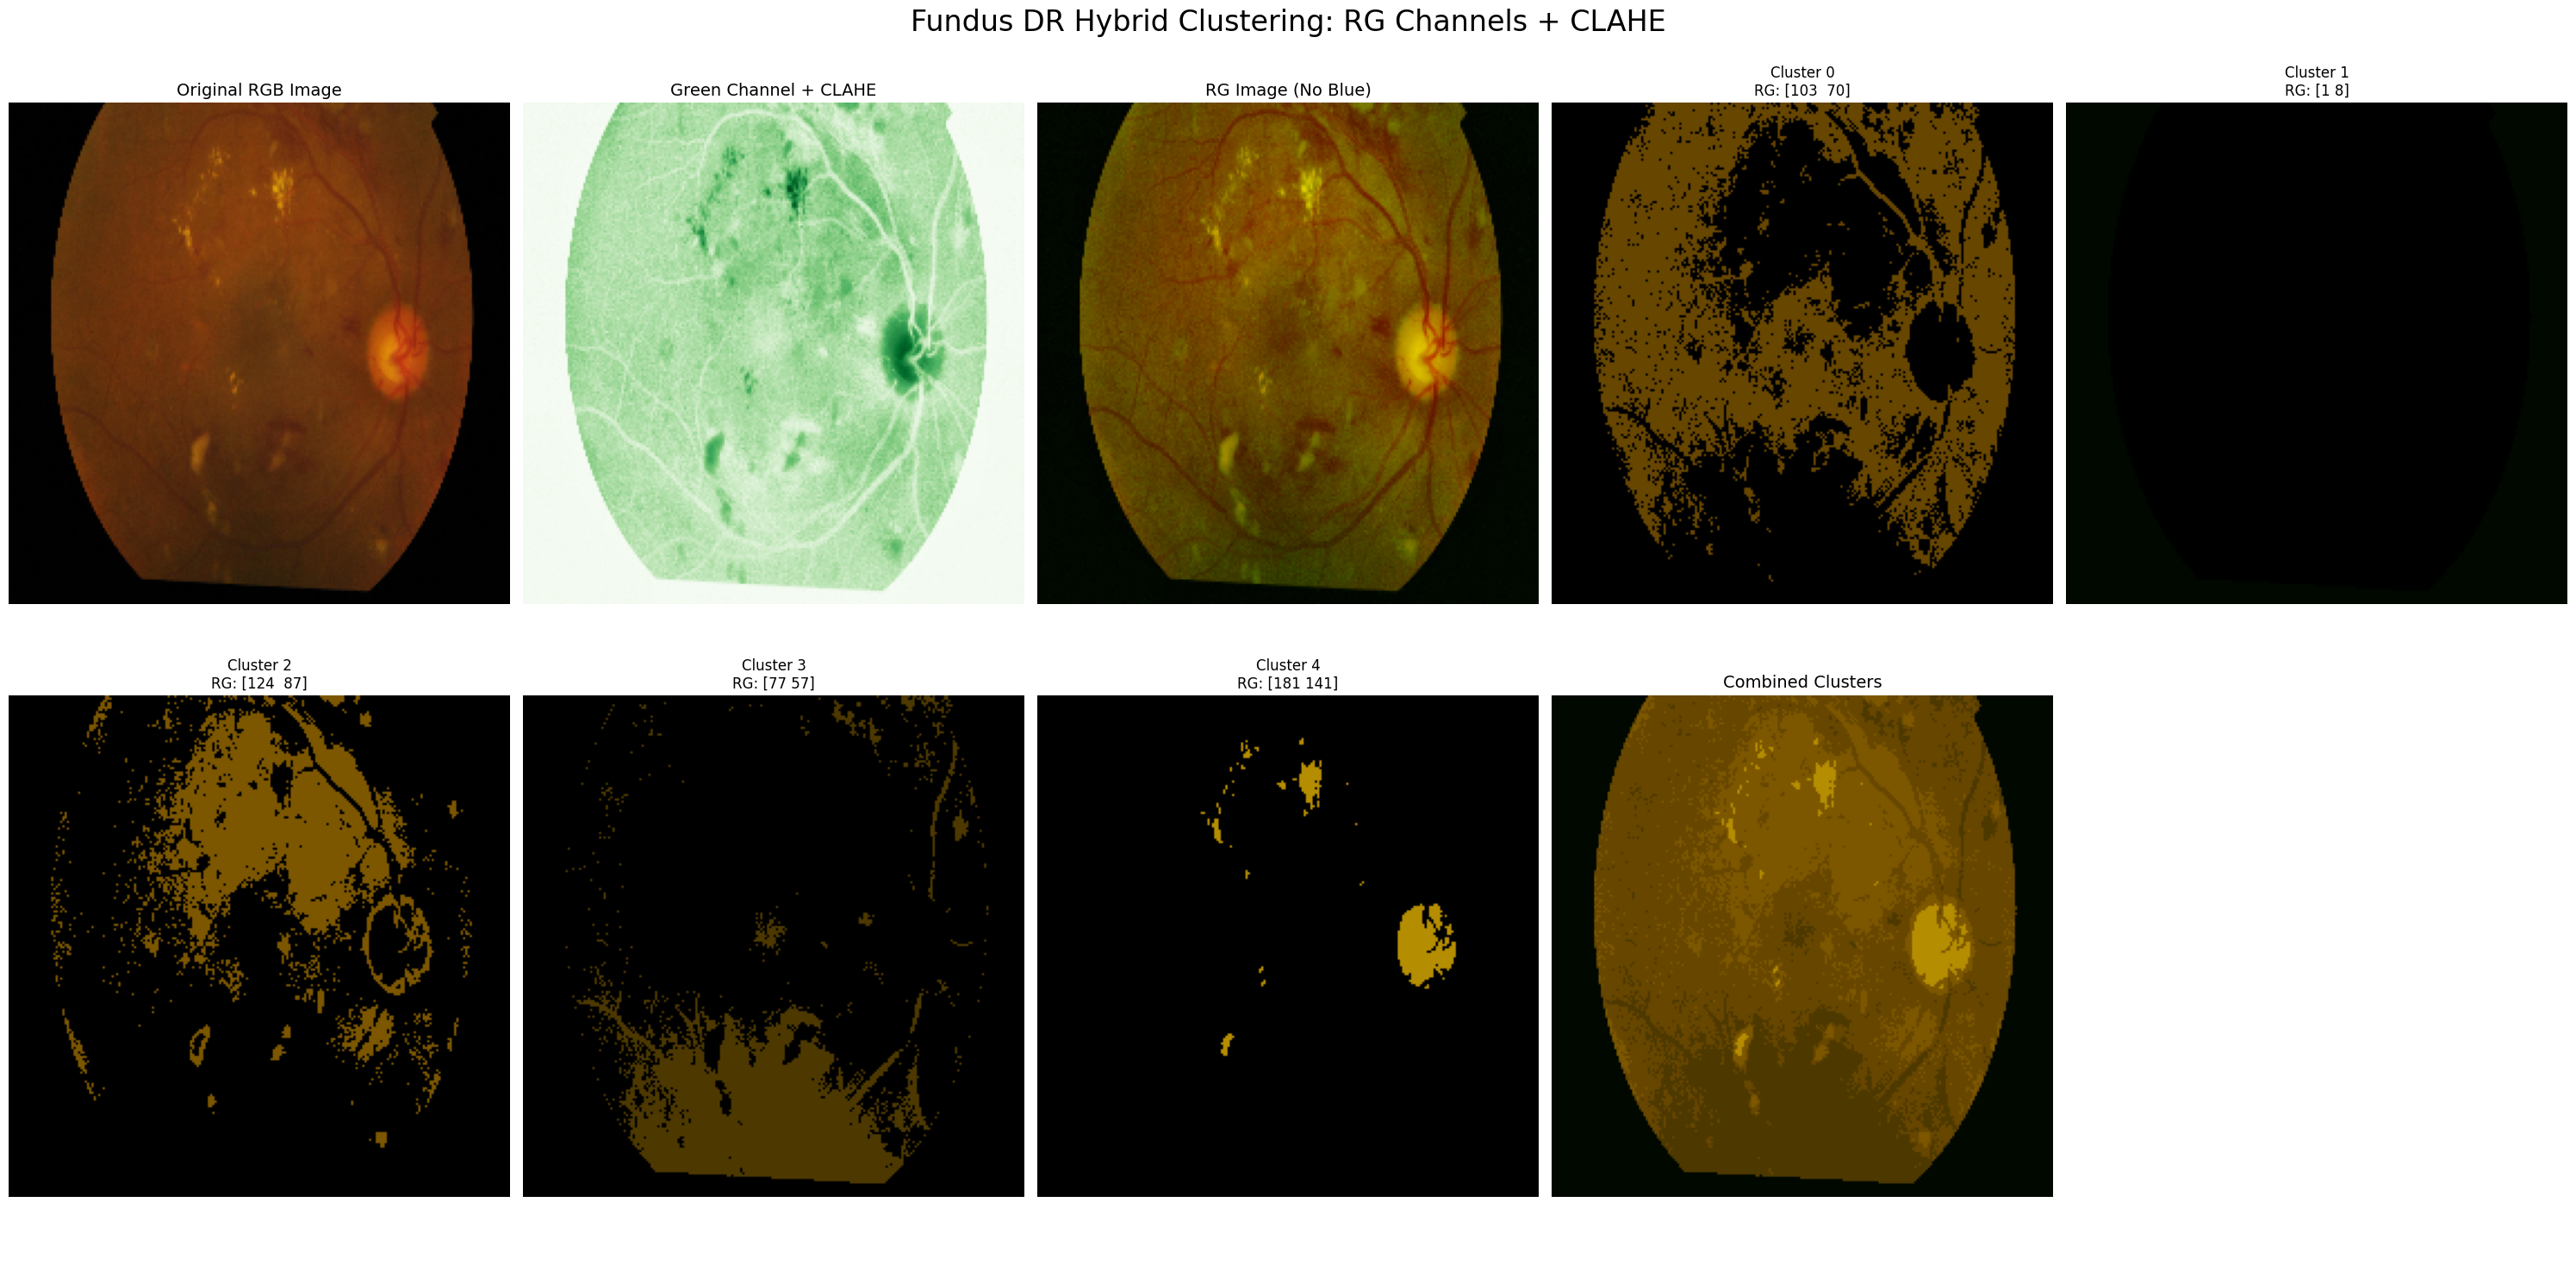


Fundus DR Clustering Quality Metrics:
Davies-Bouldin Index (DBI): 0.6573 (lower is better)
Within-Cluster Sum of Squares (WCSS): 8411728.0000
Silhouette Score: 0.5595 (higher is better)

[INFO] Analysis complete!
Key improvements for fundus DR imaging:
- Blue channel removed (less informative for retinal analysis)
- CLAHE applied to green channel (enhances blood vessels and lesions)
- Hybrid K-means + FCM clustering for better segmentation
- Spatial features included for region coherence


In [19]:
# Usage example:
results = analyze_fundus_dr_image('DR2.png', n_clusters=5)